## DCGAN IMPLEMENTATION

In this notebook I will implement [DCGAN](https://arxiv.org/abs/1511.06434) and try to generate new Faces.

Dataset of original CelebA was taken from [Kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

In [1]:
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
##Hyperparameters

LEARNING_RATE = 2e-4
BETA1 = 0.5
BETA2 = 0.999
CONV_DIM = 64
DECONV_DIM = 64
BATCH_SIZE = 64
Z_SIZE = 100
IMG_SIZE = 64
N_EPOCHS = 50


In [3]:
# Let's take a look at the images first
import torchvision.transforms.functional as F
import torch.nn as nn
from torchvision import transforms as T
from torchvision.utils import make_grid
import torch.optim as optim
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
import numpy as np


#Loading the data
def get_dataloader(batch_size, image_size, data_dir, num_workers=2):
    """
    Function to load the data and transform it. Images are resized by image_size parameter
    """

    dataset = dset.ImageFolder(root=data_dir,
                        transform=T.Compose([
                        T.Resize(image_size),
                        T.CenterCrop(image_size),
                        T.ToTensor()
                    ]))

    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=num_workers)

    return dataloader

def display_image(images):
    """
    Function to display dataloader batch
    """
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title('Pokemon Images')
    plt.imshow(np.transpose(vutils.make_grid(images[0].to(device)[:64], padding=1, normalized=True).cpu(), (1,2,0)))


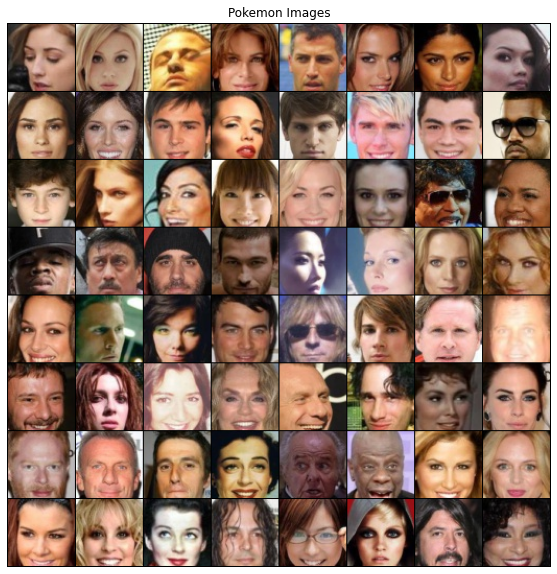

In [4]:
#Generating Data Loader and displaying first batch 
pokemon_loader = get_dataloader(BATCH_SIZE, IMG_SIZE, 'dataset/processed_celeba_small')
dataiter = next(iter(pokemon_loader))
display_image(dataiter)



### DCGAN Architecture - Generator and Discriminator

<img src='assets/DCGAN_architecture.png'>

Picture taken from [here](https://medium.com/analytics-vidhya/generative-adversarial-networks-df14100f17ed).

In [5]:
##Helper functions to create conv-deconv layers

#This one for Discriminator
def add_conv_layer(in_channels, out_channels, kernel_size= 4, stride=2, padding=1, batch_norm=True, leaky_relu=True, sigmoid=False):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)    

    #Checking if Batch Norm layer to be added
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    #Checking if leaky relu to be added
    if leaky_relu:
        layers.append(nn.LeakyReLU(0.2))
    
    if sigmoid:
        layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

#This one for Generator
def add_deconv_layer(in_channels, out_channels, kernel_size= 4, stride=2, padding=1, batch_norm=True, relu=True, tanh=False):

    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(deconv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    if relu:
        layers.append(nn.ReLU(True))

    if tanh:
        layers.append(nn.Tanh())
    
    return nn.Sequential(*layers)


In [6]:
#Function for initalize weights to help model convere. 

def initialize_weights(model):
    '''
        Based on the paper the weights were initializedfrom a zero-centered Normal distribution with standard deviation of 0.02
    '''
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.2)


In [7]:
##Classes for Discriminator and Generator


class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        '''
        Initialize Discriminator
        :param conv_dim: Depth of the first convolutional layer
        '''
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            add_conv_layer(3, conv_dim, batch_norm=False), #First conv layer no batch norm
            add_conv_layer(conv_dim, conv_dim*2), 
            add_conv_layer(conv_dim*2, conv_dim*4), 
            add_conv_layer(conv_dim*4, conv_dim*8),
            add_conv_layer(conv_dim*8, 1, stride=1, padding=0, batch_norm=False, leaky_relu=False, sigmoid=True)
        )
    
    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_size, deconv_dim):
        '''
        Initialize Generator
        :param z_size: Length of the input latent vector z
        :param deconv_dim: Depth of the input to the last transpose convolutional layer     
        '''
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            add_deconv_layer(z_size, deconv_dim*8, stride=1, padding=0),
            add_deconv_layer(deconv_dim*8, deconv_dim*4),
            add_deconv_layer(deconv_dim*4, deconv_dim*2),
            add_deconv_layer(deconv_dim*2, deconv_dim),
            add_deconv_layer(deconv_dim, 3, batch_norm=False, relu=False, tanh=True)
        )

    def forward(self, x):
        return self.gen(x)

In [8]:
## Function to create Network

def create_DCGAN(d_conv_dim, g_deconv_dim, z_size):

    D = Discriminator(d_conv_dim)
    G = Generator(z_size, g_deconv_dim)

    #Initialize weights
    D.apply(initialize_weights)
    G.apply(initialize_weights)

    return D, G 

In [9]:
#Setting up the Network

D, G = create_DCGAN(CONV_DIM, DECONV_DIM, Z_SIZE)


In [10]:
##Moving To GPU

D.to(device)
G.to(device)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [11]:
#Defining loss and optimizer

criterion = nn.BCELoss()

optimizer_gen = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1,BETA2))
optimizer_disc = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1,BETA2))


In [12]:
fixed_noise = torch.randn(BATCH_SIZE, Z_SIZE, 1, 1, device=device)


In [13]:
#Tensorboard

real_logs = SummaryWriter(f"logs/real_pokemon")
fake_logs = SummaryWriter(f"logs/fake_pokemon")


In [14]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x * (feature_range[1] - feature_range[0]) + feature_range[0]
    
    return x


In [15]:
img = dataiter[0][1]
scaled_img = scale(img)

print(scaled_img.min())
print(scaled_img.max())

tensor(-1.)
tensor(1.)


In [16]:
def train(D, G, n_epochs, print_every=50):

    step = 1

    for epoch in range(n_epochs):

        for batch_id, (real_images, _) in enumerate(pokemon_loader):
            
            

            #Discriminator training
            optimizer_disc.zero_grad()
            real = real_images.to(device)
            real = scale(real)
            #labels = torch.full((batch_size,), 1, dtype=real.dtype, device=device)
            #Real
            discriminator_real = D(real).view(-1)
            loss_discriminator_real = criterion(discriminator_real, torch.ones_like(discriminator_real).to(device))
            loss_discriminator_real.backward()
            D_x = discriminator_real.mean().item()

            #Fake
            noise = torch.randn(BATCH_SIZE, Z_SIZE, 1, 1, device=device)
            fake_images = G(noise)
            #labels.fill_(0)

            discriminator_fake = D(fake_images.detach()).view(-1)
            loss_discriminator_fake = criterion(discriminator_fake, torch.zeros_like(discriminator_fake)).to(device)
            loss_discriminator_fake.backward()
            D_G_z = discriminator_fake.mean().item()
            #Total loss discriminator
            total_loss_discriminator = loss_discriminator_real + loss_discriminator_fake
            optimizer_disc.step()


            ##Generator
            optimizer_gen.zero_grad()
            #labels.fill_(1)
            generator_output = D(fake_images).view(-1)
            loss_generator = criterion(generator_output, torch.ones_like(generator_output).to(device))
            loss_generator.backward()
            D_G_z2 = generator_output.mean().item()
            optimizer_gen.step()
            
            
            
            #Printing losses and logging to tensorboard

            if (batch_id % print_every == 0):
                print(f'Epoch [{epoch}/{N_EPOCHS}] | d_loss: {total_loss_discriminator:.4f} | g_loss: {loss_generator:.4f}')

                with torch.no_grad():
                    fake = G(fixed_noise)

                    img_grid_real = make_grid(real_images[:32], normalize=True)
                    img_grid_fake = make_grid(fake[:32], normalize=True)

                real_logs.add_image("Real", img_grid_real, global_step=step)
                fake_logs.add_image("Fake", img_grid_fake, global_step=step)

                step += 1
               







In [17]:
#Launch training
train(D, G, N_EPOCHS)

Epoch [0/50] | d_loss: 1.8158 | g_loss: 1.5879
Epoch [0/50] | d_loss: 0.2243 | g_loss: 4.1046
Epoch [0/50] | d_loss: 0.1972 | g_loss: 4.6565
Epoch [0/50] | d_loss: 0.1056 | g_loss: 5.3969
Epoch [0/50] | d_loss: 0.0793 | g_loss: 5.5692
Epoch [0/50] | d_loss: 0.0832 | g_loss: 5.6941
Epoch [0/50] | d_loss: 0.1779 | g_loss: 5.7352
Epoch [0/50] | d_loss: 0.0478 | g_loss: 6.3107
Epoch [1/50] | d_loss: 0.0467 | g_loss: 6.6091
Epoch [1/50] | d_loss: 0.0679 | g_loss: 6.2872
Epoch [1/50] | d_loss: 0.0995 | g_loss: 6.2971
Epoch [1/50] | d_loss: 0.0349 | g_loss: 6.5015
Epoch [1/50] | d_loss: 0.0556 | g_loss: 6.8452
Epoch [1/50] | d_loss: 0.0137 | g_loss: 6.9467
Epoch [1/50] | d_loss: 0.0545 | g_loss: 6.6276
Epoch [1/50] | d_loss: 0.0082 | g_loss: 7.4885
Epoch [2/50] | d_loss: 0.0165 | g_loss: 7.1126
Epoch [2/50] | d_loss: 0.0174 | g_loss: 7.1794
Epoch [2/50] | d_loss: 0.0099 | g_loss: 7.6017
Epoch [2/50] | d_loss: 0.0120 | g_loss: 7.2164
Epoch [2/50] | d_loss: 0.0105 | g_loss: 6.9363
Epoch [2/50] 